#**HOMEWORK: BLUE BIKE TRIP DURATION PREDICTION (Total: / 15 points)**

Context: You have received some data from Blue Bikes (the Boston Bikesharing Service). They have asked you to provide a predictive model that can accurately predict how long a given bike rental will last, at the time the rental begins. The use case is that the bike share company wants to be able to predict how long a customer will have the bike in their possession, when they begin their retnal, in order to better manage operational efficiency across the bike network. Note that when the customer initiates a bike rental, they enter the starting station ID and ending station ID for their trip, into the mobile app.

# *Name: (Student Name Here)*
# *Email: (Student Email Here)*

#*Import and Pre-process Data*

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

bluebikes = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2023/main/Lecture%20Materials/C_Assignment/bluebikes_sample.csv')

# This function MUST return a pair of objects (predictors, labels, in that order) as numpy arrays.

def processData(data):
    # Convert starttime to datetime object
    data['starttime'] = pd.to_datetime(data['starttime'], errors='coerce')

    # Create new columns for the hour, day of the week, month, and year when the trip started
    data['start_hour'] = data['starttime'].dt.hour
    data['start_day_of_week'] = data['starttime'].dt.dayofweek
    data['start_month'] = data['starttime'].dt.month
    data['start_year'] = data['starttime'].dt.year

    # Extract start and end station IDs
    data['start_station_id'] = data['start station name'].str.extract('(\d+)', expand=False).astype(float)
    data['end_station_id'] = data['end station name'].str.extract('(\d+)', expand=False).astype(float)

    # Calculate trip duration in minutes
    data['tripduration_minutes'] = data['tripduration'] / 60

    # Drop unnecessary columns
    predictors = data.drop(columns=['tripduration', 'starttime', 'stoptime', 'start station name', 'end station name', 'bikeid'])

    # Fill in missing values with the median of the corresponding column
    predictors = predictors.fillna(predictors.median())

    # One-hot encode the usertype column
    predictors = pd.concat([predictors, pd.get_dummies(predictors['usertype'], drop_first=True)], axis=1)
    predictors = predictors.drop(columns=['usertype'])

    # Normalize/standardize the features
    scaler = StandardScaler()
    predictors_scaled = scaler.fit_transform(predictors)

    # Convert to numpy arrays
    predictors = predictors_scaled
    labels = data['tripduration'].to_numpy()

    return predictors, labels





#*Specify Your Neural Network Architecture, Process Your Sample*

Calling the data pre-processing function on the sample.

In [2]:
predictors, labels = processData(bluebikes)

<ipython-input-1-9de7458416be>:35: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  predictors = predictors.fillna(predictors.median())


Specifying my Neural Network's structure. Note that the important thing for performance with this model actually comes down to its depth! It turns out that width isn't that important here. 


In [3]:
# Define early stopping and learning rate reduction callbacks
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Split the data into training and validation sets
train_predictors, val_predictors, train_labels, val_labels = train_test_split(predictors, labels, test_size=0.2)

# Build the model
def build_model():
    # create a sequential model
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=[train_predictors.shape[1]]),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)
    ])

    # compile the model with the mean squared error loss and the adam optimizer
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

    return model




#*Train Your Neural Network Here*

In [9]:
model = build_model()

# Train the model with callbacks
history = model.fit(train_predictors, train_labels, batch_size=64, epochs=100, 
                    validation_data=(val_predictors, val_labels),
                    callbacks=[early_stop, reduce_lr])

# Evaluate the model
mse, mae = model.evaluate(val_predictors, val_labels)
print('Validation mean squared error:', mse)
print('Validation mean absolute error:', mae)

Epoch 1/100
113/113 [==============================] - 2s 5ms/step - loss: 2628924.2500 - mae: 772.5240 - val_loss: 1740044.6250 - val_mae: 637.9975 - lr: 0.0010
Epoch 2/100
113/113 [==============================] - 0s 4ms/step - loss: 1951969.8750 - mae: 493.5150 - val_loss: 1120445.2500 - val_mae: 453.1169 - lr: 0.0010
Epoch 3/100
113/113 [==============================] - 0s 4ms/step - loss: 1549659.7500 - mae: 449.7785 - val_loss: 968975.9375 - val_mae: 432.8170 - lr: 0.0010
Epoch 4/100
113/113 [==============================] - 0s 4ms/step - loss: 1245422.7500 - mae: 430.3916 - val_loss: 811872.0625 - val_mae: 406.7035 - lr: 0.0010
Epoch 5/100
113/113 [==============================] - 0s 4ms/step - loss: 990596.3125 - mae: 401.5221 - val_loss: 648886.6875 - val_mae: 371.8777 - lr: 0.0010
Epoch 6/100
113/113 [==============================] - 0s 4ms/step - loss: 1024174.1250 - mae: 366.4260 - val_loss: 464397.6875 - val_mae: 322.5735 - lr: 0.0010
Epoch 7/100
113/113 [============

Plot your model performance over training here:

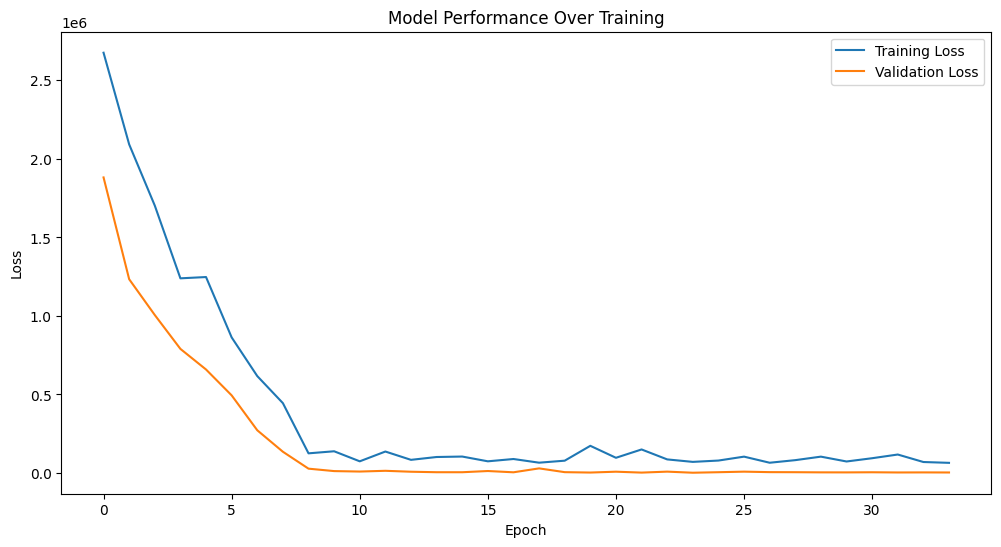

In [8]:
# Plot the model performance
plt.figure(figsize=(12, 6))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Set the title and labels for the axes
plt.title('Model Performance Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

#*Choose Final Configuration and Produce That Model Here:*

In [6]:
model = build_model()
model.fit(predictors,labels,epochs=100, batch_size=50) # for example

Epoch 1/100
180/180 [==============================] - 2s 3ms/step - loss: 2338133.0000 - mae: 716.3681
Epoch 2/100
180/180 [==============================] - 1s 3ms/step - loss: 1591740.2500 - mae: 457.1145
Epoch 3/100
180/180 [==============================] - 1s 3ms/step - loss: 990560.2500 - mae: 416.4163
Epoch 4/100
180/180 [==============================] - 1s 3ms/step - loss: 749217.4375 - mae: 364.7162
Epoch 5/100
180/180 [==============================] - 1s 3ms/step - loss: 298451.6562 - mae: 272.6808
Epoch 6/100
180/180 [==============================] - 1s 3ms/step - loss: 162630.8281 - mae: 186.1717
Epoch 7/100
180/180 [==============================] - 1s 3ms/step - loss: 111587.9141 - mae: 159.8768
Epoch 8/100
180/180 [==============================] - 1s 3ms/step - loss: 109427.2344 - mae: 152.0572
Epoch 9/100
180/180 [==============================] - 1s 3ms/step - loss: 145972.0938 - mae: 149.5443
Epoch 10/100
180/180 [==============================] - 1s 3ms/step - l

Here's what the resulting model looks like.

In [10]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               2176      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                

#*Final Evaluation*

Don't modify this section; this is the code I will use to evaluate that your model is output properly and that it can generate predictions on new test observations it has never seen before. If your model breaks when I feed it the new data, I will deduct marks, so please ensure that your data pre-processing function works properly!

In [11]:
from google.colab import files
import io

# I'm going to upload my holdout dataset (same set of features)
uploaded = files.upload()
bluebike_holdout = pd.read_csv(io.BytesIO(uploaded['bluebikes_holdout.csv']))

# I'm then going to pre-process it using your commands.
holdout_predictors, holdout_labels = processData(bluebike_holdout)

# Then I'm going to evaluate your model's performance on that data.
loss_metrics = model.evaluate(holdout_predictors,holdout_labels,verbose=1)

KeyboardInterrupt: ignored